In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from datetime import datetime

print('Load in...')

Load in...


In [10]:
BASEDIR = '../datasets/mode_2003/'
filenames = os.listdir(BASEDIR)
print(len(filenames))
csvname = os.path.join(BASEDIR, [it for it in filenames if '.csv' in it][0])
print(csvname)
df_train = pd.read_csv(csvname)
print(df_train.info())

42164
../../datasets/cloud/mode_2003/data_I2003.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42163 entries, 0 to 42162
Data columns (total 26 columns):
num_id                    42163 non-null int64
Scene_ID                  42163 non-null object
K-J                       42163 non-null int64
Date                      42163 non-null object
Time                      42163 non-null object
SPOT                      42163 non-null int64
HRV                       42163 non-null int64
Mode                      42163 non-null object
Upper_Left_Latitude       42163 non-null object
Upper_Left_Longitude      42163 non-null object
Upper_Right_Latitude      42163 non-null object
Upper_Right_Longitude     42163 non-null object
Scene_Centre_Latitude     42163 non-null object
Scene_Centre_Longitude    42163 non-null object
Lower_Left_Latitude       42163 non-null object
Lower_Left_Longitude      42163 non-null object
Lower_Right_Latitude      42163 non-null object
Lower_Right_Longitude     4

In [12]:
import random

def binary_sample(_, thresh=0.8):
    return 'T' if np.random.uniform(0.0, 1.0) < thresh else 'F'
    
df_train['Train'] = df_train['num_id'].map(binary_sample)

print('Numbers of images for training', df_train.loc[df_train['Train'] == 'F']['num_id'].count())
print('Numbers of images for evaluation', df_train.loc[df_train['Train'] == 'T']['num_id'].count())

df_train.to_csv(csvname)
print(df_train.info())

Numbers of images for training 8209
Numbers of images for evaluation 33954
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42163 entries, 0 to 42162
Data columns (total 27 columns):
num_id                    42163 non-null int64
Scene_ID                  42163 non-null object
K-J                       42163 non-null int64
Date                      42163 non-null object
Time                      42163 non-null object
SPOT                      42163 non-null int64
HRV                       42163 non-null int64
Mode                      42163 non-null object
Upper_Left_Latitude       42163 non-null object
Upper_Left_Longitude      42163 non-null object
Upper_Right_Latitude      42163 non-null object
Upper_Right_Longitude     42163 non-null object
Scene_Centre_Latitude     42163 non-null object
Scene_Centre_Longitude    42163 non-null object
Lower_Left_Latitude       42163 non-null object
Lower_Left_Longitude      42163 non-null object
Lower_Right_Latitude      42163 non-null object
Lowe

In [9]:
type(df_train['num_id'].count())

numpy.int64

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v2, resnet_v1
import numpy as np
import pandas as pd
import os, sys
from datetime import datetime
ERROR_FLAG = 0

pretrain_dir = './checkpoints/resnet_v1_152.ckpt'
model_dir = './checkpoints/models/resnet_ordinal.model'
data_dir = '../datasets/mode_2004/'
logdir = './logs/'
optimizer = 'SGD'
losstype = 'ordinal'
is_training = True
batch_size = 8
learning_rate = 0.01
pretrained = True

def save(sess, model_dir, counter):
	if not os.path.exists(model_dir):
		os.makedirs(self.model_dir)
	save_path = saver.save(sess, model_dir, global_step=counter)
	print('MODEL RESTORED IN: ' + save_path)


def load(sess, model_dir):
	import re
	print(' [*] Reading checkpoints...')
	ckpt = tf.train.get_checkpoint_state(model_dir)
	saver = tf.train.Saver(max_to_keep=1)
	if ckpt and ckpt.model_checkpoint_path:
		ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
		saver.restore(sess, model_dir + ckpt_name)
		counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
		print(" [*] Success to read {}".format(ckpt_name))
		return counter
	else:
		print(" [*] Failed to find a checkpoint")
		return ERROR_FLAG

def get_counter(model_dir):
	import re
	print(' [*] Reading checkpoints...')
	ckpt = tf.train.get_checkpoint_state(model_dir)
	if ckpt and ckpt.model_checkpoint_path:
		ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
		print(" [*] Success to read {}".format(ckpt_name))
		return int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
	else:
		print(" [*] Failed to find a checkpoint")
		return ERROR_FLAG

def init_reader(path=data_dir, batch_size=8, epoch=10, is_training=True):
	def _parse_function(xs, ys):
		x_img_str = tf.read_file(xs)
		x_img_decoded = tf.image.convert_image_dtype(tf.image.decode_jpeg(x_img_str), tf.float32)
		x_img_resized = tf.image.resize_images(x_img_decoded, size=[512, 512],
		                                       method=tf.image.ResizeMethod.BILINEAR)
		return x_img_resized, ys

	# Processing the image filenames
	fs = os.listdir(path)
	csv_name = os.path.join(path, [it for it in fs if '.csv' in it][0])

	# Add one more column named "Train" to split the training set and validation set
	if is_training:
		frame = pd.read_csv(csv_name)
		frame = frame.loc[frame['Train'] == 'T']
		print(' [*] {} images initialized as training data'.format(frame['num_id'].count()))
	else:
		frame = pd.read_csv(csv_name)
		frame = frame.loc[frame['Train'] == 'F']
		print(' [*] {} images initialized as validation data'.format(frame['num_id'].count()))

	num_idx = frame['num_id'].values.astype(str).tolist()
	t_names = [item + '.jpg' for item in num_idx]
	file_names = [os.path.join(path, item) for item in t_names]
	labels = frame['Cloud_Cover'].values.tolist()
	t_labels = [list('F'.join(item.split('*'))) for item in labels]
	for it in range(len(t_labels)):
		t_labels[it] = list(map(lambda x: ord(x) - ord('A'), t_labels[it]))
	# Initialize as a tensorflow tensor object
	data = tf.data.Dataset.from_tensor_slices((tf.constant(file_names),
	                                           tf.constant(t_labels)))
	data = data.map(_parse_function)
	if is_training:
		return data.shuffle(buffer_size=1024).batch(batch_size).repeat(epoch)
	else:
		return data.batch_size(batch_size)
    
def init_loss(logits, labels, end_points=None, losstype='ordinal'):
	if end_points is not None:
		# Definition of binary network for better classification of "*"
		# The network has only 3 layers, with the front-end being resnet_v1_152/block3
		# See the graph in tensorboard for more detailed information
		conv_1 = slim.conv2d(end_points['resnet_v1_152/block4'], 64, [3, 3], scope='conv_1')
		conv_2 = slim.conv2d(conv_1, 1, [3, 3], scope='conv_2')
		reshaped = tf.reshape(conv_2, [batch_size*8, -1], name='reshaped')
		binary = slim.fully_connected(reshaped, 1, activation_fn=None, scope='fc_3')
		binary_labels = tf.reshape(tf.cast(tf.equal(labels, 5), tf.float32), [-1, 1], name='binary_labels')
		binary_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=binary_labels,
		                                                      logits=binary)
		binary_loss = tf.reduce_mean(binary_loss, name='binary_loss')
	
	# Here we start our cross entropy loss definition
	if losstype == 'cross_entropy':
		loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, 
		                                                      logits=logits)
		return tf.reduce_mean(loss, name='loss') + binary_loss, binary
	elif losstype == 'ordinal':
		import math
		ks = [np.arange(1, 7).astype(np.float32)[None, :] \
		       for _ in range(batch_size * 8)]
		ks = np.concatenate(ks, axis=0)
		kfac = [[math.factorial(it) for it in range(1, 7)] for _ in range(batch_size * 8)]
		kfac = np.array(kfac, dtype=np.float32)
		k_vector = tf.constant(ks, name='k_vector')
		k_factor = tf.constant(kfac, name='k_factor')
		softmaxed = tf.nn.softmax(logits, axis=-1, name='softmax')
		log_exp = tf.log(softmaxed)
		poisson = k_vector * log_exp - logits - tf.log(k_factor)
		loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
		                                                      logits=poisson)
		return tf.reduce_mean(loss, name='loss') + binary_loss, binary
	else:
		raise NotImplementedError

with tf.device(tf.DeviceSpec(device_type='GPU')):
    reader = init_reader(data_dir, batch_size=batch_size)
    batch_xs, batch_ys = reader.make_one_shot_iterator().get_next()
    # param batch_xs: shape [-1, 512, 512, 3] type tf.float32
    # param batch_ys: shape [-1] type tf.int32
    off_ws = [0, 0, 0, 0, 256, 256, 256, 256]
    off_hs = [0, 128, 256, 384, 0, 128, 256, 384]
    x_img_cuts = [tf.image.crop_to_bounding_box(batch_xs, hs, ws, 128, 256)\
                    for hs, ws in zip(off_hs, off_ws)]
    batch_xs = tf.reshape(tf.concat(x_img_cuts, axis=0), [batch_size*8, 128, 256, 3])
    batch_ys = tf.reshape(batch_ys, [batch_size * 8])

# if is_training:
#     with slim.arg_scope(resnet_v1.resnet_arg_scope()):
#         logits, end_points = resnet_v1.resnet_v1_152(batch_xs, num_classes=6, 
#                                                                                                  is_training=True)
#         logits = tf.reshape(logits, [-1, 6], name='logits_2d')
#         prediction = tf.argmax(logits, axis=-1, output_type=tf.int32)
#         mAP = tf.reduce_mean(tf.cast(tf.equal(prediction, batch_ys), 
#                                      dtype=tf.float32))
#         loss, _ = init_loss(logits, batch_ys, end_points=end_points, losstype=losstype)
#         mAP_sum = tf.summary.scalar('mAP', mAP)
#         loss_sum = tf.summary.scalar('loss', loss)
#         summaries = tf.summary.merge([mAP_sum, loss_sum])

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     sess = tf.InteractiveSession(config=config)
#     counter = get_counter(model_dir)

#     # Exponential decay learning rate and optimizer configurations
#     learning_rate = tf.train.exponential_decay(learning_rate, counter, 
#                                                100, 0.98, staircase=True)
#     if 'SGD' in optimizer:
#         optim = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, 
#                                                                           global_step=tf.Variable(counter))
#     elif 'Adam' in optimizer:
#         optim = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=tf.Variable(counter))
#     else:
#         optim = None
#         raise NotImplementedError
#     sess.run(tf.global_variables_initializer())

#     if pretrained:
#         # Load the pretrained model given by TensorFlow official
#         exclusions = ['resnet_v1_152/logits', 'predictions']
#         resnet_except_logits = slim.get_variables_to_restore(exclude=exclusions)
#         init_fn = slim.assign_from_checkpoint_fn(pretrain_dir, resnet_except_logits,
#                                                  ignore_missing_vars=True)
#         init_fn(sess)
#         print('Model successfully loaded')
#     else:
#         # Load the model trained by ourselves
#         counter = load(sess, model_dir)

# Ready to train
# train(sess, optim, loss, summaries, FLAGS.loops, counter=counter)
# print('Training finished')

 [*] 41804 images initialized as training data


In [2]:
with tf.device(tf.DeviceSpec(device_type='GPU')):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.InteractiveSession(config=config)

sess.run(tf.global_variables_initializer())
print(' [*] Initialized...')

 [*] Initialized...


In [4]:
print(batch_xs, batch_ys)

Tensor("Reshape:0", shape=(64, 128, 256, 3), dtype=float32) Tensor("Reshape_1:0", shape=(64,), dtype=int32)


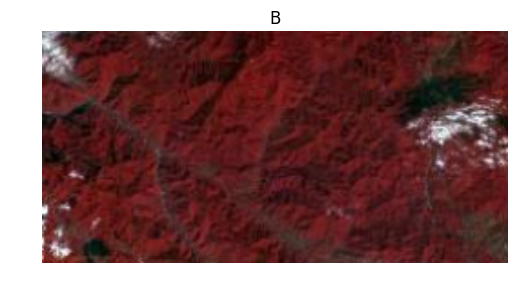

In [55]:
xs, ys = sess.run([batch_xs, batch_ys])
assign = ['A', 'B', 'C', 'D', 'E', '*']

plt.close()
plt.figure()
plt.imshow(xs[0, :, :, :])
plt.title(assign[ys[0]])
plt.axis('off')
plt.show()